In [1]:
using Distributions
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

x ⪅ y = x < y || x ≈ y
_ecdf(A, x) = count(≤(x), A) / length(A)

pvalue_central(dist, x) = min(1, 2cdf(dist, x), 2ccdf(dist, x-1))

function pvalue_minlike(dist, x)
    m = mode(dist)
    x == m && return 1.0
    px = pdf(dist, x)
    if x < m
        y = m
        while !(pdf(dist, y) ⪅ px) y += 1 end
        cdf(dist, x) + ccdf(dist, y-1)
    else
        y = m
        while !(pdf(dist, y) ⪅ px) y -= 1 end
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_normal_approx(dist, x; correction=0.0)
    absz = max(0, abs(x - mean(dist)) - correction) / std(dist)
    2ccdf(Normal(), absz)
end

function pvalue_gamma_approx_eti(dist, x; correction=0.0)
    μ, σ² = mean(dist), var(dist)
    κ, θ = μ^2/σ², σ²/μ
    gamma = Gamma(κ, θ)
    m = median(gamma)
    min(1, 2cdf(gamma, min(m, x + correction)), 2ccdf(gamma, max(m, x - correction)))
end

function pvalue_hdi(dist, x;
        xmin = minimum(dist) == -Inf ? -1e8 : minimum(dist),
        xmax = maximum(dist) ==  Inf ?  1e8 : maximum(dist),
        correction = 0.0,
    )
    m = mode(dist)
    px = pdf(dist, x)
    px ≈ pdf(dist, m) && return 1.0
    f(y) = pdf(dist, y) - px
    if x < m
        y = find_zero(f, (m, 1.0))
        cdf(dist, min(m, x + correction)) + ccdf(dist, max(m, y - correction))
    else
        y = find_zero(f, (0.0, m))
        cdf(dist, min(m, y + correction)) + ccdf(dist, max(m, x - correction))
    end
end

function pvalue_gamma_approx_hdi(dist, x; correction=0.0)
    μ, σ² = mean(dist), var(dist)
    κ, θ = μ^2/σ², σ²/μ
    gamma = Gamma(κ, θ)
    pvalue_hdi(gamma, x; correction)
end

loglikrat(dist1, dist0, x) = 2(logpdf(dist1, x) - logpdf(dist0, x))
pvalue_loglikrat(dist1, dist0, x; df = 1) = ccdf(Chisq(df), loglikrat(dist1, dist0, x))

function pvalue_score(k, n, p)
    p̂ = k/n
    χ² = (p̂ - p)^2 / (p*(1-p)/n)
    ccdf(Chisq(1), χ²)
end

function pvalue_logmaxlikrat(k, n, p)
    p̂ = k/n
    χ² = 2(xlogy(k, p̂/p) + xlogy(n-k, (1-p̂)/(1-p)))
    ccdf(Chisq(1), χ²)
end

function pvalue_bayes_eti(k, n, p; prior=Beta(1, 1))
    κ, λ = params(prior)
    beta = Beta(κ+k, λ+n-k)
    min(1, 2cdf(beta, p), 2ccdf(beta, p))
end

function pvalue_bayes_hdi(k, n, p; prior=Beta(1, 1))
    κ, λ = params(prior)
    beta = Beta(κ+k, λ+n-k)
    pvalue_hdi(beta, p)
end

function sim_bin(n, p; L=10^5)
    bin = Binomial(n, p)
    pval_score = zeros(L)
    pval_lmlr = zeros(L)
    pval_central = zeros(L)
    pval_minlike = zeros(L)
    Threads.@threads for i in 1:L
        k = rand(bin)
        pval_score[i] = pvalue_score(k, n, p)
        pval_lmlr[i] = pvalue_logmaxlikrat(k, n, p)
        pval_central[i] = pvalue_central(bin, k)
        pval_minlike[i] = pvalue_minlike(bin, k)
    end
    pval_score, pval_lmlr, pval_central, pval_minlike
end

function sim_negbin(k, p; L=10^5)
    negbin = NegativeBinomial(k, p) + k
    pval_score = zeros(L)
    pval_lmlr = zeros(L)
    pval_central = zeros(L)
    pval_minlike = zeros(L)
    Threads.@threads for i in 1:L
        n = rand(negbin)
        pval_score[i] = pvalue_score(k, n, p)
        pval_lmlr[i] = pvalue_logmaxlikrat(k, n, p)
        pval_central[i] = pvalue_central(negbin, n)
        pval_minlike[i] = pvalue_minlike(negbin, n)
    end
    pval_score, pval_lmlr, pval_central, pval_minlike
end

function pdf_invnegbin(x; k=7, p=0.5) # x = k/n
    0 < x ≤ 1 || return 0.0
    negbin = NegativeBinomial(k, p) + k
    n = round(Int, k/x)
    w = k/max(k, n-1/2) - k/(n+1/2)
    pdf(negbin, n) / w
end

function plot_invnegbin(; k=7, p=0.5, xmin=0.0, xmax=1.0)
    negbin = NegativeBinomial(k, p) + k
    @show μ = sum(k/n * pdf(negbin, n) for n in k:10^3)
    @show σ = √sum((k/n - μ)^2 * pdf(negbin, n) for n in k:10^3)
    @show k/μ, mean(negbin)
    plot(x -> pdf_invnegbin(x; k, p), xmin, xmax; label="inv.neg.bin.")
    plot!(Normal(μ, σ), xmin, xmax; label="normal approx.")
end

function print_result(k, n, p; prior=Beta(1, 1))
    @show k n p
    bin = bin0 = Binomial(n, p)
    bin1 = Binomial(n, k/n)
    negbin = negbin0 = NegativeBinomial(k, p) + k
    negbin1 = NegativeBinomial(k, k/n) + k
    println()
    #@show mean(bin) std(bin)
    #@show (k - mean(bin)) / std(bin)
    #@show loglikrat(bin1, bin0, k)
    #@show pvalue_loglikrat(bin1, bin0, k)
    @show pvalue_normal_approx(bin, k)
    @show pvalue_central(bin, k)
    @show pvalue_normal_approx(bin, k; correction=0.5)
    @show pvalue_minlike(bin, k)
    println()
    #@show mean(negbin) std(negbin)
    #@show (n - mean(negbin)) / std(negbin)
    #@show loglikrat(negbin1, negbin0, n)
    #@show pvalue_loglikrat(negbin1, negbin0, n)
    @show pvalue_central(negbin, n)
    @show pvalue_gamma_approx_eti(negbin, n; correction=0.5)
    #@show pvalue_gamma_approx_eti(negbin, n)
    @show pvalue_minlike(negbin, n)
    #@show pvalue_normal_approx(negbin, n; correction=0.5)
    #@show pvalue_normal_approx(negbin, n)
    @show pvalue_gamma_approx_hdi(negbin, n; correction=0.5)
    #@show pvalue_gamma_approx_hdi(negbin, n)
    println()
    #@show pvalue_logmaxlikrat(k, n, p)
    @show pvalue_score(k, n, p)
    #@show pvalue_bayes_eti(k, n, p; prior)
    @show pvalue_bayes_hdi(k, n, p; prior)
end

function plot_negbin(k, p)
    negbin = NegativeBinomial(k, p) + k
    #@show negbin
    @show μ, σ² = mean(negbin), var(negbin)
    @show κ, θ = μ^2/σ², σ²/μ
    σ = √σ²
    P1 = bar(negbin; alpha=0.3, label="NegativeBinomial($k, $p) + $k")
    plot!(Normal(μ, σ); label="normal approx.", lw=2)
    plot!(Gamma(κ, θ); label="gamma approx.", ls=:dash, lw=2)
    plot!(legend=:outertop, xlim=(μ-5σ, μ+5σ))
end

function print_and_plot_result(k, n, p; prior=Beta(1, 1))
    print_result(k, n, p; prior)
    println()
    plot_negbin(k, p)
end

print_and_plot_result (generic function with 1 method)

μ = sum(((k / n) * pdf(negbin, n) for n = k:10 ^ 3)) = 0.5353635972529502
σ = √(sum(((k / n - μ) ^ 2 * pdf(negbin, n) for n = k:10 ^ 3))) = 0.1405043707129707
(k / μ, mean(negbin)) = (13.075225950957996, 14.0)


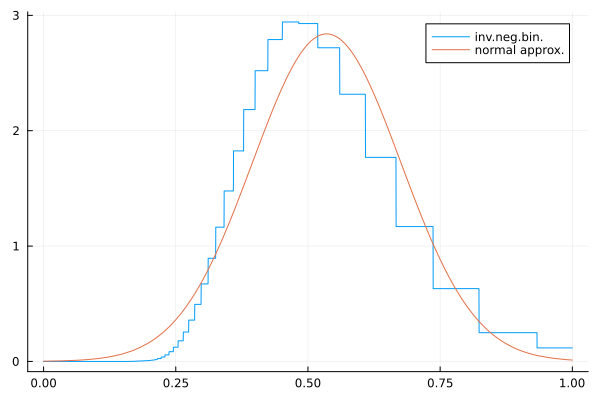

In [2]:
plot_invnegbin(k=7, p=0.5)

k = 12
n = 24
p = 0.3

pvalue_normal_approx(bin, k) = 0.03250944464571947
pvalue_central(bin, k) = 0.062787308191949
pvalue_normal_approx(bin, k; correction = 0.5) = 0.055445049572222405
pvalue_minlike(bin, k) = 0.04326778062052104

pvalue_central(negbin, n) = 0.06278730819194901
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.07298043311282425
pvalue_minlike(negbin, n) = 0.09820592118181828
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.602164746064744

pvalue_score(k, n, p) = 0.0325094446457195
pvalue_bayes_hdi(k, n, p; prior) = 0.034939481052115244

(μ, σ²) = (mean(negbin), var(negbin)) = (40.0, 93.33333333333331)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (17.142857142857146, 2.333333333333333)


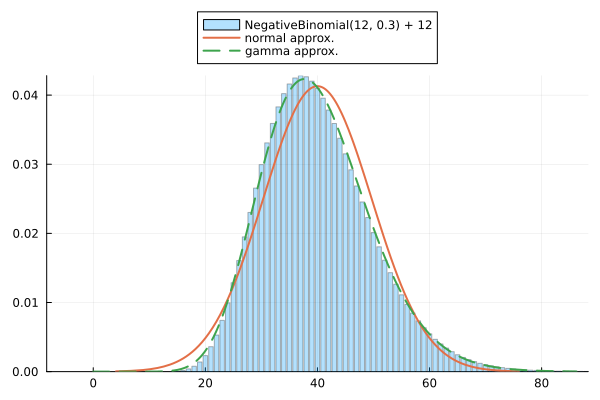

In [3]:
print_and_plot_result(12, 24, 0.3)

k = 33
n = 80
p = 0.3

pvalue_normal_approx(bin, k) = 0.028108040147151795
pvalue_central(bin, k) = 0.042278565270654704
pvalue_normal_approx(bin, k; correction = 0.5) = 0.03809903617986084
pvalue_minlike(bin, k) = 0.03720393373713992

pvalue_central(negbin, n) = 0.04227856527065471
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.046811270277612005
pvalue_minlike(negbin, n) = 0.054515418694282385
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.5624505620530361

pvalue_score(k, n, p) = 0.028108040147151837
pvalue_bayes_hdi(k, n, p; prior) = 0.03136233727484138

(μ, σ²) = (mean(negbin), var(negbin)) = (110.0, 256.66666666666663)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (47.14285714285715, 2.333333333333333)


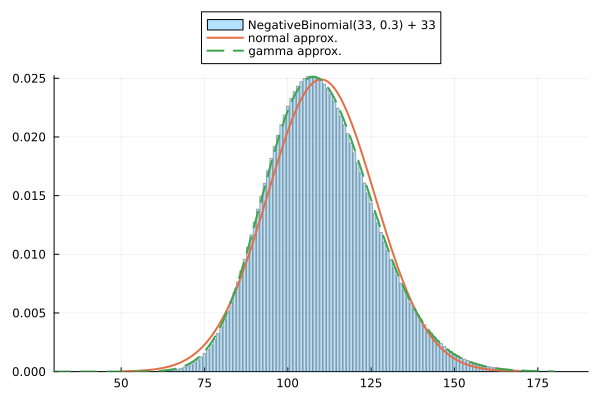

In [4]:
print_and_plot_result(33, 80, 0.3)

k = 87
n = 240
p = 0.3

pvalue_normal_approx(bin, k) = 0.034610557515707366
pvalue_central(bin, k) = 0.04377214216533209
pvalue_normal_approx(bin, k; correction = 0.5) = 0.04110630826596563
pvalue_minlike(bin, k) = 0.040803390933980305

pvalue_central(negbin, n) = 0.04377214216533213
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.04625335279271409
pvalue_minlike(negbin, n) = 0.051338871183208734
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.547055007219937

pvalue_score(k, n, p) = 0.034610557515707366
pvalue_bayes_hdi(k, n, p; prior) = 0.03733433170128422

(μ, σ²) = (mean(negbin), var(negbin)) = (290.0, 676.6666666666666)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (124.28571428571429, 2.333333333333333)


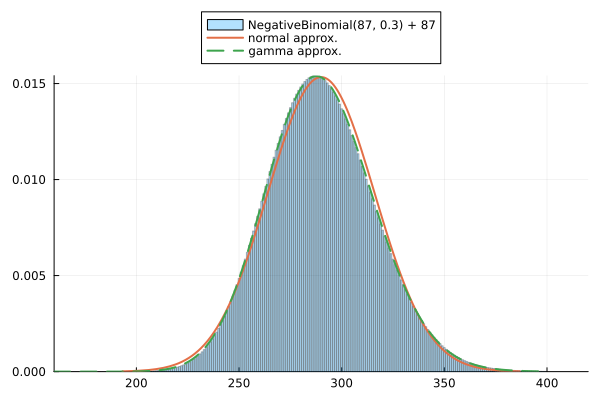

In [5]:
print_and_plot_result(87, 240, 0.3)

k = 7
n = 24
p = 0.5

pvalue_normal_approx(bin, k) = 0.041226833337163676
pvalue_central(bin, k) = 0.06391465663909922
pvalue_normal_approx(bin, k; correction = 0.5) = 0.06619257972219343
pvalue_minlike(bin, k) = 0.06391465663909922

pvalue_central(negbin, n) = 0.034689664840698284
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.027398096343670568
pvalue_minlike(negbin, n) = 0.017344832420349142
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.020968296818052734

pvalue_score(k, n, p) = 0.041226833337163704
pvalue_bayes_hdi(k, n, p; prior) = 0.033141477034471095

(μ, σ²) = (mean(negbin), var(negbin)) = (14.0, 14.0)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (14.0, 1.0)


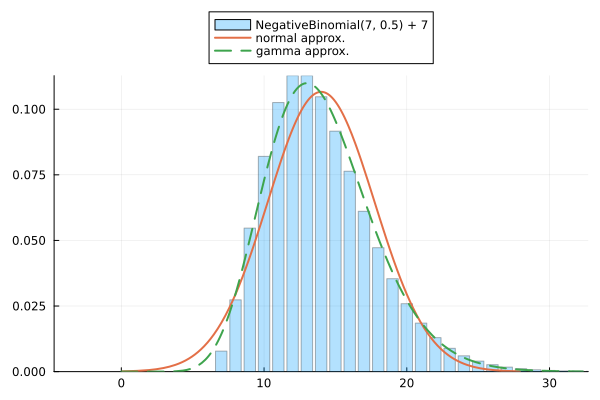

In [6]:
print_and_plot_result(7, 24, 1/2)

k = 31
n = 80
p = 0.5

pvalue_normal_approx(bin, k) = 0.04417134490844261
pvalue_central(bin, k) = 0.05666442634512109
pvalue_normal_approx(bin, k; correction = 0.5) = 0.05734685190136638
pvalue_minlike(bin, k) = 0.05666442634512109

pvalue_central(negbin, n) = 0.04216544399495108
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.03718882330647951
pvalue_minlike(negbin, n) = 0.02912990201311296
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.03145478242981718

pvalue_score(k, n, p) = 0.04417134490844264
pvalue_bayes_hdi(k, n, p; prior) = 0.04139511622307178

(μ, σ²) = (mean(negbin), var(negbin)) = (62.0, 62.0)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (62.0, 1.0)


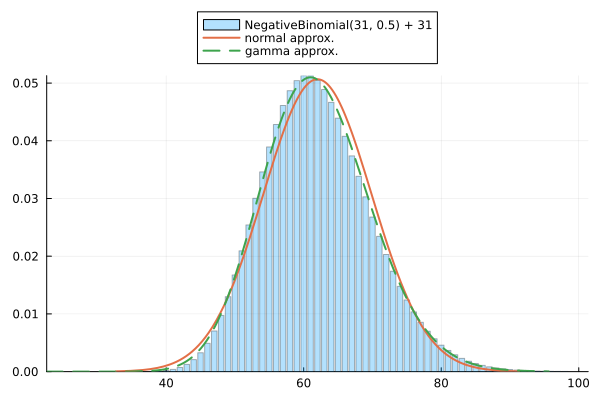

In [7]:
print_and_plot_result(31, 80, 1/2)

k = 105
n = 240
p = 0.5

pvalue_normal_approx(bin, k) = 0.05280751141611362
pvalue_central(bin, k) = 0.06098896169225595
pvalue_normal_approx(bin, k; correction = 0.5) = 0.061214634954601985
pvalue_minlike(bin, k) = 0.06098896169225595

pvalue_central(negbin, n) = 0.05208653072726427
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.0488109347352462
pvalue_minlike(negbin, n) = 0.04460340308883083
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.044296176307870125

pvalue_score(k, n, p) = 0.05280751141611362
pvalue_bayes_hdi(k, n, p; prior) = 0.051770296780320205

(μ, σ²) = (mean(negbin), var(negbin)) = (210.0, 210.0)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (210.0, 1.0)


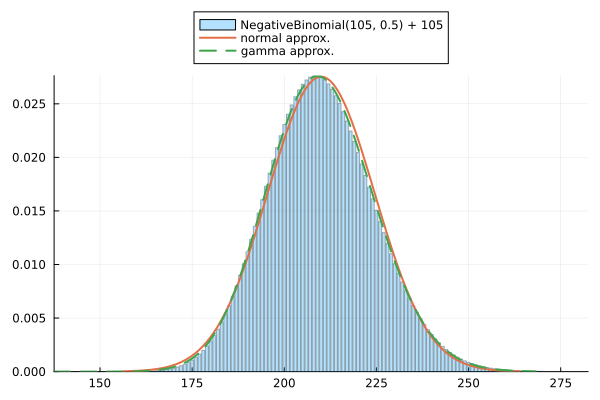

In [8]:
print_and_plot_result(105, 240, 1/2)

k = 469
n = 1000
p = 0.5

pvalue_normal_approx(bin, k) = 0.0499242840396975
pvalue_central(bin, k) = 0.05367784964501021
pvalue_normal_approx(bin, k; correction = 0.5) = 0.05373218155818342
pvalue_minlike(bin, k) = 0.05367784964501021

pvalue_central(negbin, n) = 0.049755537281934256
pvalue_gamma_approx_eti(negbin, n; correction = 0.5) = 0.04808781133728488
pvalue_minlike(negbin, n) = 0.046226643264490344
pvalue_gamma_approx_hdi(negbin, n; correction = 0.5) = 0.04580173648499138

pvalue_score(k, n, p) = 0.04992428403969736
pvalue_bayes_hdi(k, n, p; prior) = 0.04967997408548473

(μ, σ²) = (mean(negbin), var(negbin)) = (938.0, 938.0)
(κ, θ) = (μ ^ 2 / σ², σ² / μ) = (938.0, 1.0)


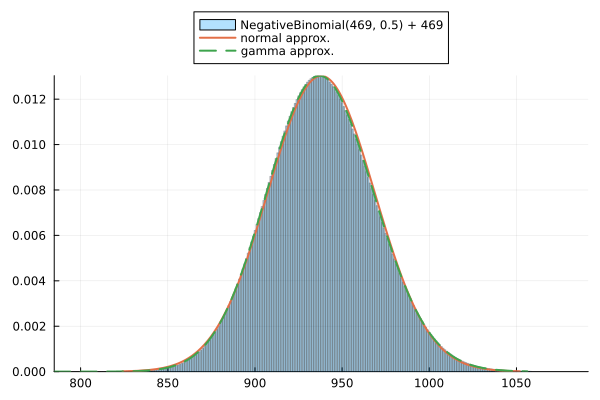

In [9]:
print_and_plot_result(469, 1000, 1/2)

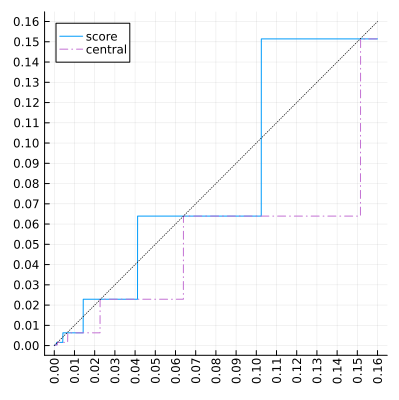

In [10]:
pval_score, pval_lmlr, pval_central, pval_minlike = sim_bin(24, 0.5)

plot(α -> _ecdf(pval_score, α), 0, 0.16; label="score")
#plot!(α -> _ecdf(pval_lmlr, α); label="log max.lik.rat.", ls=:dash, c=2)
#plot!(α -> _ecdf(pval_minlike, α); label="minlike", ls=:dashdotdot, c=3)
plot!(α -> _ecdf(pval_central, α); label="central", ls=:dashdot, c=4)
plot!(identity; label="", c=:black, ls=:dot, lw=0.7)
plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
plot!(size=(400, 400))

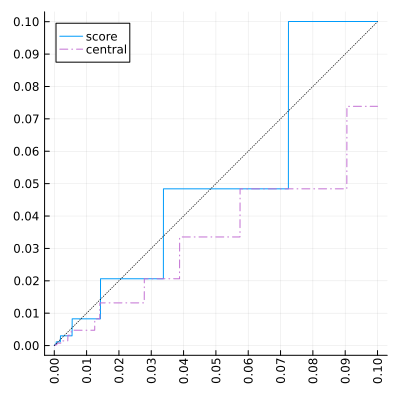

In [11]:
pval_score, pval_lmlr, pval_central, pval_minlike = sim_bin(50, 0.25)

plot(α -> _ecdf(pval_score, α), 0, 0.1; label="score")
#plot!(α -> _ecdf(pval_lmlr, α); label="log max.lik.rat.", ls=:dash, c=2)
#plot!(α -> _ecdf(pval_minlike, α); label="minlike", ls=:dashdotdot, c=3)
plot!(α -> _ecdf(pval_central, α); label="central", ls=:dashdot, c=4)
plot!(identity; label="", c=:black, ls=:dot, lw=0.7)
plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
plot!(size=(400, 400))

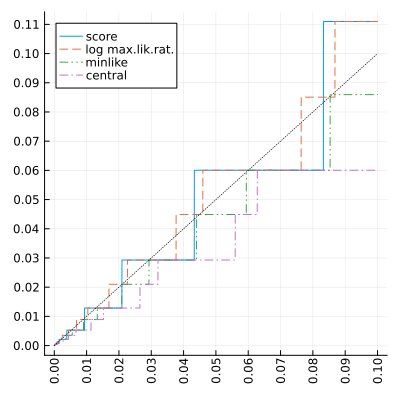

In [12]:
pval_score, pval_lmlr, pval_central, pval_minlike = sim_bin(50, 0.4)

plot(α -> _ecdf(pval_score, α), 0, 0.1; label="score")
plot!(α -> _ecdf(pval_lmlr, α); label="log max.lik.rat.", ls=:dash, c=2)
plot!(α -> _ecdf(pval_minlike, α); label="minlike", ls=:dashdotdot, c=3)
plot!(α -> _ecdf(pval_central, α); label="central", ls=:dashdot, c=4)
plot!(identity; label="", c=:black, ls=:dot, lw=0.7)
plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
plot!(size=(400, 400))

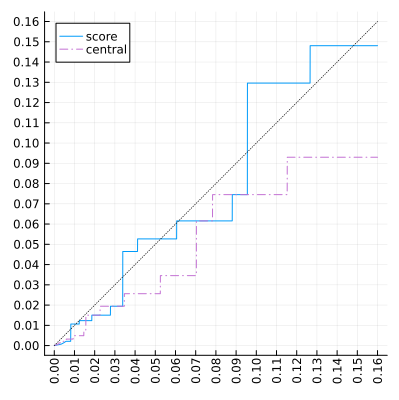

In [13]:
pval_score, pval_lmlr, pval_central, pval_minlike = sim_negbin(7, 0.5)

plot(α -> _ecdf(pval_score, α), 0, 0.16; label="score")
#plot!(α -> _ecdf(pval_lmlr, α); label="log max.lik.rat.", ls=:dash, c=2)
#plot!(α -> _ecdf(pval_minlike, α); label="minlike", ls=:dashdotdot, c=3)
plot!(α -> _ecdf(pval_central, α); label="central", ls=:dashdot, c=4)
plot!(identity; label="", c=:black, ls=:dot, lw=0.7)
plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
plot!(size=(400, 400))

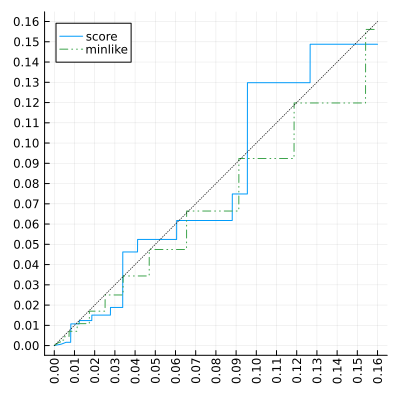

In [14]:
pval_score, pval_lmlr, pval_central, pval_minlike = sim_negbin(7, 0.5)

plot(α -> _ecdf(pval_score, α), 0, 0.16; label="score")
#plot!(α -> _ecdf(pval_lmlr, α); label="log max.lik.rat.", ls=:dash, c=2)
plot!(α -> _ecdf(pval_minlike, α); label="minlike", ls=:dashdotdot, c=3)
#plot!(α -> _ecdf(pval_central, α); label="central", ls=:dashdot, c=4)o
plot!(identity; label="", c=:black, ls=:dot, lw=0.7)
plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
plot!(size=(400, 400))

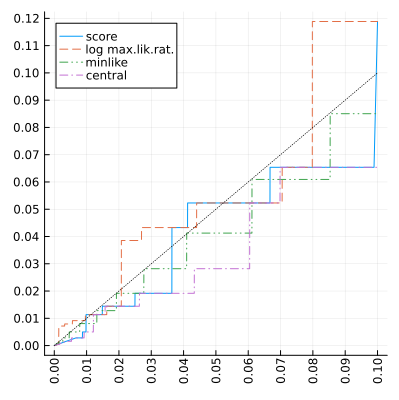

In [15]:
pval_score, pval_lmlr, pval_central, pval_minlike = sim_negbin(10, 0.6)

plot(α -> _ecdf(pval_score, α), 0, 0.1; label="score")
plot!(α -> _ecdf(pval_lmlr, α); label="log max.lik.rat.", ls=:dash, c=2)
plot!(α -> _ecdf(pval_minlike, α); label="minlike", ls=:dashdotdot, c=3)
plot!(α -> _ecdf(pval_central, α); label="central", ls=:dashdot, c=4)
plot!(identity; label="", c=:black, ls=:dot, lw=0.7)
plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
plot!(size=(400, 400))

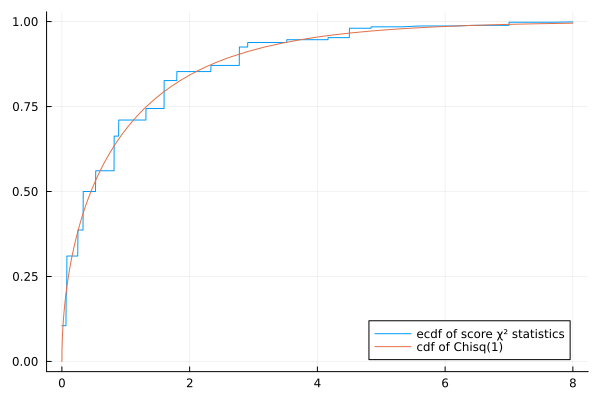

In [16]:
function plot_negbin_chisq(; k=7, p=0.5, xmin=0.0, xmax=8.0, L=10^5)
    negbin = NegativeBinomial(k, p) + k
    scorechisq = [(k/n - p)^2/(p*(1-p)/n) for n in (rand(negbin) for _ in 1:L)]
    plot(x -> _ecdf(scorechisq, x), xmin, xmax; label="ecdf of score χ² statistics")
    plot!(x -> cdf(Chisq(1), x); label="cdf of Chisq(1)")
end

plot_negbin_chisq(k=7, p=0.5)

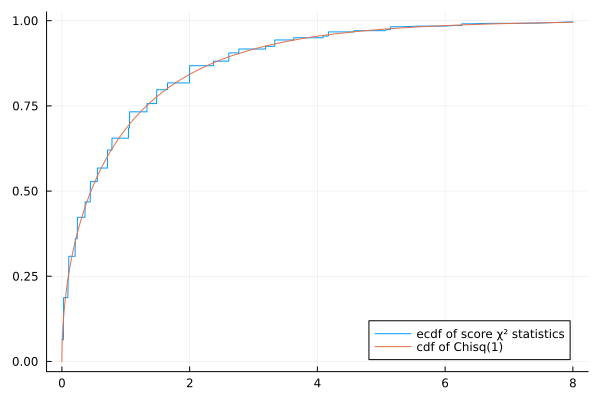

In [17]:
plot_negbin_chisq(k=20, p=0.5)

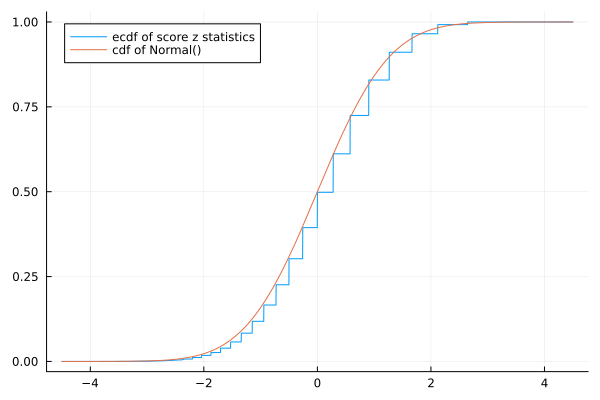

In [18]:
function plot_negbin_z(; k=7, p=0.5, xmin=-4.5, xmax=4.5, L=10^5)
    negbin = NegativeBinomial(k, p) + k
    scorez = [(k/n - p)/√(p*(1-p)/n) for n in (rand(negbin) for _ in 1:L)]
    plot(x -> _ecdf(scorez, x), xmin, xmax; label="ecdf of score z statistics")
    plot!(x -> cdf(Normal(), x), xmin, xmax; label="cdf of Normal()")
end

plot_negbin_z(k=7, p=0.5)

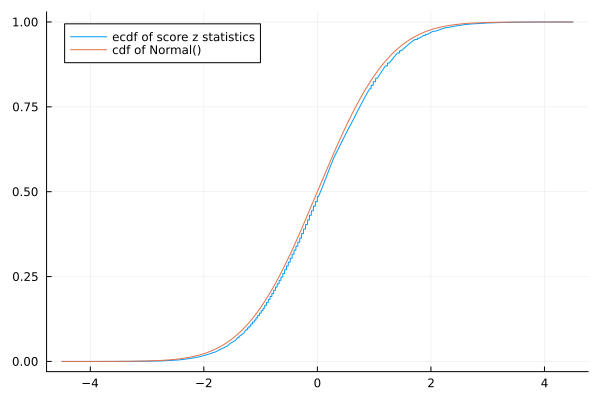

In [19]:
plot_negbin_z(k=40, p=0.2)